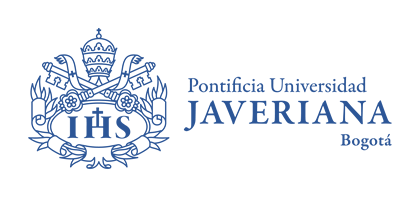

# Entrega # 1 Proyecto final - Redes neuronales para la clasificación de tumores de seno




Este notebook corresponde a la primera entrega que consiste en dar solución a el problema de clasificación de tumores de seno utilizando técnicas de aprendizaje profundo

Entregado por: 
   * Nikolas Rodriguez     
   * Angie Zapata 
   * Nicolas Mendez
   * Cristian Cristancho

## Importar librerias 

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [43]:
from tensorflow.keras.layers import Dense, Input, Conv2D, Conv2DTranspose,UpSampling2D, Flatten, Reshape, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint 
from tensorflow.keras.utils import plot_model

from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

## Leer el dataset 
Descargado del repositorio https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29

In [3]:
df = pd.read_csv('../Datos/Breast Cancer Prediction.csv')
df.head()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


### Análisis Exploratorio de los Datos 
Listado de variables indicando la cantidad de registros no nulos de cada uno y el tipo de variable

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Sample code number           683 non-null    int64
 1   Clump Thickness              683 non-null    int64
 2   Uniformity of Cell Size      683 non-null    int64
 3   Uniformity of Cell Shape     683 non-null    int64
 4   Marginal Adhesion            683 non-null    int64
 5   Single Epithelial Cell Size  683 non-null    int64
 6   Bare Nuclei                  683 non-null    int64
 7   Bland Chromatin              683 non-null    int64
 8   Normal Nucleoli              683 non-null    int64
 9   Mitoses                      683 non-null    int64
 10  Class                        683 non-null    int64
dtypes: int64(11)
memory usage: 58.8 KB


Verificar cantidad de nulos en cada variable

In [5]:
pd.DataFrame({'Missing Values': df.isna().sum()})

,Missing Values
Sample code number,0
Clump Thickness,0
Uniformity of Cell Size,0
Uniformity of Cell Shape,0
Marginal Adhesion,0
Single Epithelial Cell Size,0
Bare Nuclei,0
Bland Chromatin,0
Normal Nucleoli,0
Mitoses,0


Breve análisis descriptivo del dataset

In [6]:
df.describe()

,Sample code number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


Observar distribuciones de las variables

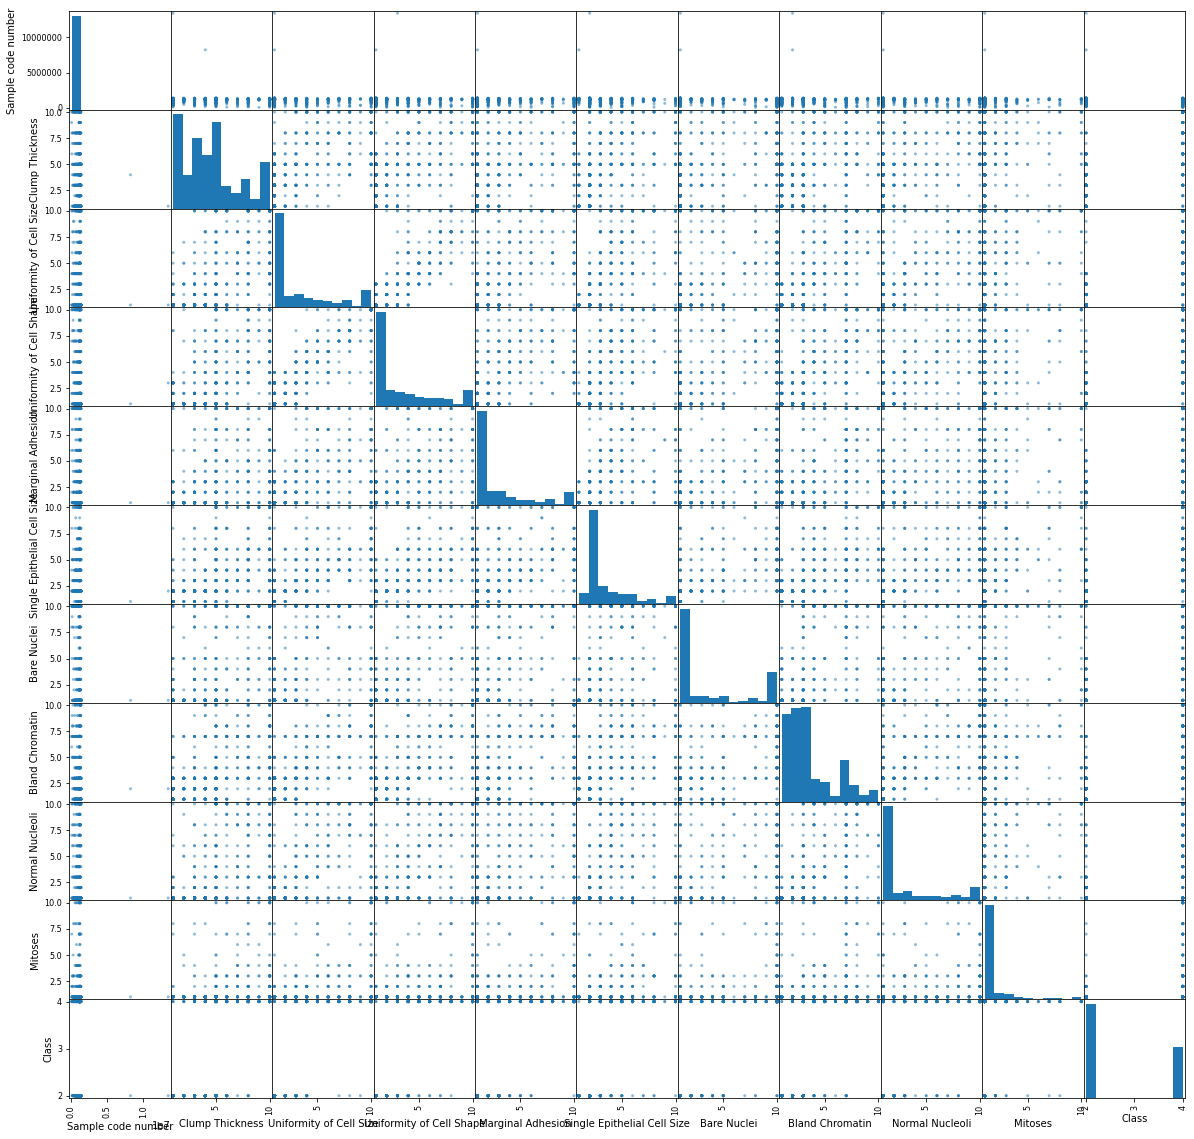

In [10]:
pd.plotting.scatter_matrix(df, figsize=(20,20));

## Observar Matriz de Correlaciones 

<AxesSubplot:>

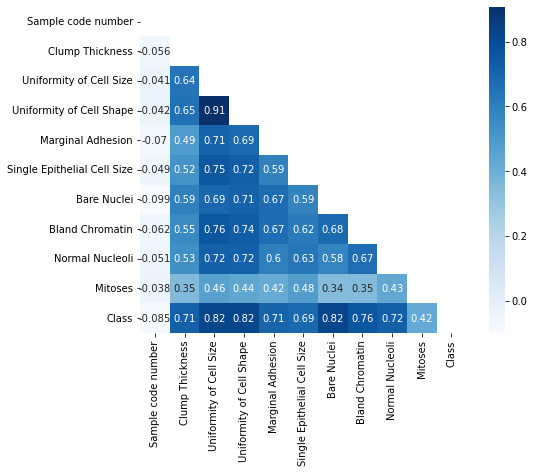

In [8]:
mask = np.zeros_like(df.corr())
tri_ind = np.triu_indices_from(mask)
mask[tri_ind] = True
plt.figure(figsize=[8, 6])
sns.heatmap(data=df.corr(), annot=True, mask=mask, cmap='Blues', square=True)

## Seleccion de los valores con los que se va a entrenar el modelo

In [12]:
X = pd.DataFrame()
X[['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli']] = df[['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']]

In [13]:
X

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,5,1,1,1,2,1,3,1,1
1,5,4,4,5,7,10,3,2,1
2,3,1,1,1,2,2,3,1,1
3,6,8,8,1,3,4,3,7,1
4,4,1,1,3,2,1,3,1,1
...,...,...,...,...,...,...,...,...,...
678,3,1,1,1,3,2,1,1,1
679,2,1,1,1,2,1,1,1,1
680,5,10,10,3,7,3,8,10,2
681,4,8,6,4,3,4,10,6,1


In [14]:
Y = pd.DataFrame()
Y[['Class']] = df[['Class']]

In [15]:
Y

,Class
0,2
1,2
2,2
3,2
4,2
...,...
678,2
679,2
680,4
681,4


## Preprocesamiento de los datos de entrada

Etapa de normalización para permitir un mejor funcionamiento de los algoritmos de optimización del error

Se utiliza la técnica de normalización: 

$
\frac{x-\bar{x}}{std(x)} 
$

In [16]:
normalized_X=(X-X.mean())/X.std()
normalized_X

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,0.197760,-0.701698,-0.741230,-0.638897,-0.555202,-0.698341,-0.181694,-0.612478,-0.348145
1,0.197760,0.277049,0.262591,0.757477,1.693925,1.771569,-0.181694,-0.284896,-0.348145
2,-0.511269,-0.701698,-0.741230,-0.638897,-0.555202,-0.423907,-0.181694,-0.612478,-0.348145
3,0.552274,1.582044,1.601018,-0.638897,-0.105376,0.124962,-0.181694,1.353016,-0.348145
4,-0.156754,-0.701698,-0.741230,0.059290,-0.555202,-0.698341,-0.181694,-0.612478,-0.348145
...,...,...,...,...,...,...,...,...,...
678,-0.511269,-0.701698,-0.741230,-0.638897,-0.105376,-0.423907,-0.998122,-0.612478,-0.348145
679,-0.865783,-0.701698,-0.741230,-0.638897,-0.555202,-0.698341,-0.998122,-0.612478,-0.348145
680,0.197760,2.234542,2.270232,0.059290,1.693925,-0.149472,1.859375,2.335764,0.228998
681,-0.156754,1.582044,0.931805,0.408383,-0.105376,0.124962,2.675803,1.025434,-0.348145


Ahora se procedera a codificar la salida del modelo entre 0 y 1, donde 0 corresponde a un tumor benigno y 1 a un tumor maligno

In [17]:
Y = Y['Class'].apply(lambda x: 1 if x==4 else 0 )

In [18]:
Y

0      0
1      0
2      0
3      0
4      0
      ..
678    0
679    0
680    1
681    1
682    1
Name: Class, Length: 683, dtype: int64

## Separacion entre los conjuntos de Train, Validation y Test

In [23]:
X_numpy = normalized_X.to_numpy()
X_numpy.shape

(683, 9)

In [26]:
Y_numpy = Y.to_numpy()
Y_numpy = np.reshape(Y_numpy, (Y_numpy.shape[0], 1))
Y_numpy.shape

(683, 1)

## Se va implementar una distribucion de 70% en Train, 15% en Valid y 15% en Test

In [39]:
X_train, X_rem, y_train, y_rem = train_test_split(X_numpy,Y_numpy, train_size=0.7)

X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

print(f'Datos en Train: {X_train.shape[0]}')
print(f'Datos en Valid: {X_valid.shape[0]}')
print(f'Datos en Test: {X_test.shape[0]}')

Datos en Train: 478
Datos en Valid: 102
Datos en Test: 103


# Definicion del modelo

In [69]:
input_layer = Input(shape=(9,))
layer = Dense(16, activation='relu')(input_layer)
layer = Dropout(0.2)(layer)
out_layer=Dense(1,activation='sigmoid')(layer)

In [70]:
cancer_detection_model = Model(inputs=input_layer,outputs=out_layer)
cancer_detection_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                160       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


# Definicion de las metricas a emplear en el modelo

In [71]:
METRICS = [
    Recall(name='recall'),
    BinaryAccuracy(name='accuracy'),
    Precision(name='precision')
]

cancer_detection_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)

## Entrenamiento del modelo

In [72]:
epochs = 40

history = cancer_detection_model.fit(X_train,y_train,
                validation_data=(X_valid,y_valid),
                epochs=epochs,
                verbose=1)

Epoch 1/40
15/15 [==============================] - 1s 11ms/step - loss: 0.4069 - recall: 0.9048 - accuracy: 0.8996 - precision: 0.8261 - val_loss: 0.3583 - val_recall: 0.9730 - val_accuracy: 0.9804 - val_precision: 0.9730
Epoch 2/40
15/15 [==============================] - 0s 1ms/step - loss: 0.3385 - recall: 0.9821 - accuracy: 0.9644 - precision: 0.9218 - val_loss: 0.2981 - val_recall: 0.9730 - val_accuracy: 0.9804 - val_precision: 0.9730
Epoch 3/40
15/15 [==============================] - 0s 1ms/step - loss: 0.2952 - recall: 0.9345 - accuracy: 0.9456 - precision: 0.9128 - val_loss: 0.2498 - val_recall: 0.9730 - val_accuracy: 0.9804 - val_precision: 0.9730
Epoch 4/40
15/15 [==============================] - 0s 1ms/step - loss: 0.2508 - recall: 0.9583 - accuracy: 0.9623 - precision: 0.9360 - val_loss: 0.2129 - val_recall: 0.9730 - val_accuracy: 0.9804 - val_precision: 0.9730
Epoch 5/40
15/15 [==============================] - 0s 2ms/step - loss: 0.2074 - recall: 0.9583 - accuracy: 0.9

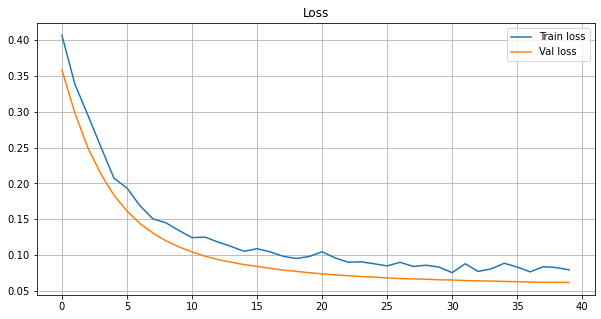

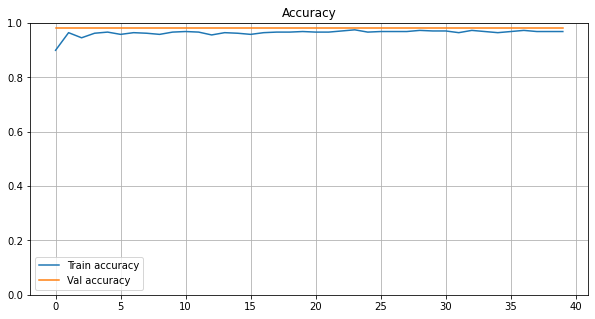

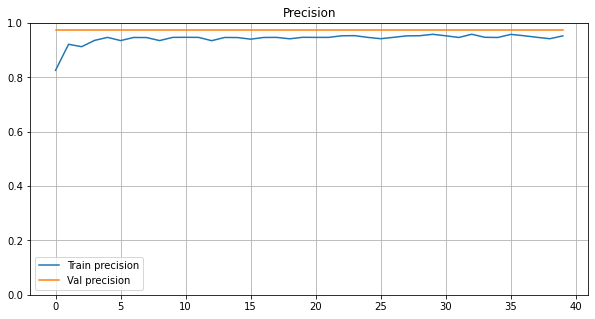

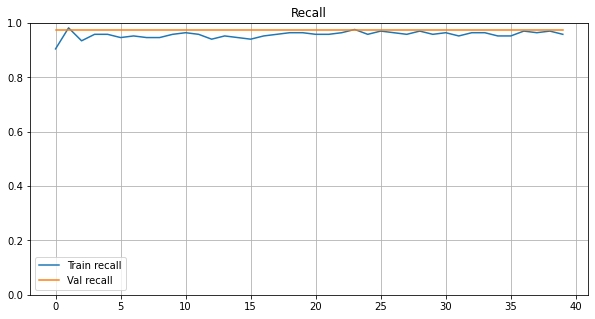

In [73]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'],label='Train loss')
plt.plot(history.history['val_loss'],label='Val loss')
plt.title('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'],label='Train accuracy')
plt.plot(history.history['val_accuracy'],label='Val accuracy')
plt.ylim((0, 1))
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['precision'],label='Train precision')
plt.plot(history.history['val_precision'],label='Val precision')
plt.ylim((0, 1))
plt.title('Precision')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['recall'],label='Train recall')
plt.plot(history.history['val_recall'],label='Val recall')
plt.ylim((0, 1))
plt.title('Recall')
plt.legend()
plt.grid()
plt.show()

# Prueba del modelo en datos de Test

In [79]:
y_test_predict = cancer_detection_model.predict(X_test)
y_test_predict = 1*(y_test_predict>0.5)

In [86]:
def get_metricas(y_true, y_pred):

  print("""
  Accuracy: """ + str(accuracy_score(y_true, y_pred)) + """
  Precision: """ + str(precision_score(y_true, y_pred)) + """
  Recall: """ + str(recall_score(y_true, y_pred)) + """
  """)

  ConfusionMatrixDisplay.from_predictions(y_true, y_pred)


  Accuracy: 0.970873786407767
  Precision: 0.9428571428571428
  Recall: 0.9705882352941176
  


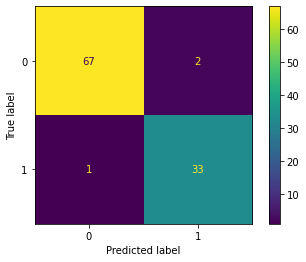

In [87]:
get_metricas(y_test, y_test_predict)